# Лабораторна робота №1

Студентки Ярки Ірини, КН-413 <br>
Варіант 11 <br>
Завдання: <br>
Вибрати з інтернету набори зображень з різною контрастністю і різним флуктуаціями  освітленості. Для кожного зображення побудувати варіант спотвореного (видозміненого  зображення). Для кожної отриманої пари побудувати дескриптор і проаналізувати  можливість суміщення цих зображень і з визначення параметрів геметричних перетворень  (кут повороту, зміщень в напрямку х і напрямку y). <br>
11. ORB <br>
Для перевірки збігів необхідно написати власну функцію матчінгу, а результати її роботи  перевірити засобами OpenCV. Якщо повної реалізації дескриптора не має в OpenCV, то  такий необхідно створити власну функцію побудови цих дискрипторів. У цьому випадку  матчінг можна здійснювати стандартними засобами (якщо це можливо). 


In [1]:
import numpy as np
from scipy.signal import convolve2d
from scipy.spatial.distance import cdist


def FAST(img, N=9, threshold=0.15, nms_window=2):
    kernel = np.array([[1,2,1],
                       [2,4,2],
                       [1,2,1]])/16
    
    img = convolve2d(img, kernel, mode='same')

    cross_idx = np.array([[3,0,-3,0], [0,3,0,-3]])
    circle_idx = np.array([[3,3,2,1,0,-1,-2,-3,-3,-3,-2,-1,0,1,2,3],
                           [0,1,2,3,3,3,2,1,0,-1,-2,-3,-3,-3,-2,-1]])

    corner_img = np.zeros(img.shape)
    keypoints = []
    for y in range(3, img.shape[0]-3):
        for x in range(3, img.shape[1]-3):
            Ip = img[y,x]
            t = threshold*Ip if threshold < 1 else threshold
            if np.count_nonzero(Ip+t < img[y+cross_idx[0,:], x+cross_idx[1,:]]) >= 3 or np.count_nonzero(Ip-t > img[y+cross_idx[0,:], x+cross_idx[1,:]]) >= 3:
                if np.count_nonzero(img[y+circle_idx[0,:], x+circle_idx[1,:]] >= Ip+t) >= N or np.count_nonzero(img[y+circle_idx[0,:], x+circle_idx[1,:]] <= Ip-t) >= N:
                    keypoints.append([x,y])
                    corner_img[y,x] = np.sum(np.abs(Ip - img[y+circle_idx[0,:], x+circle_idx[1,:]]))

    if nms_window != 0:
        fewer_kps = []
        for [x, y] in keypoints:
            window = corner_img[y-nms_window:y+nms_window+1, x-nms_window:x+nms_window+1]
            loc_y_x = np.unravel_index(window.argmax(), window.shape)
            x_new = x + loc_y_x[1] - nms_window
            y_new = y + loc_y_x[0] - nms_window
            new_kp = [x_new, y_new]
            if new_kp not in fewer_kps:
                fewer_kps.append(new_kp)
    else:
        fewer_kps = keypoints

    return np.array(fewer_kps)

def corner_orientations(img, corners):
    OFAST_MASK = np.zeros((31, 31), dtype=np.int32)
    OFAST_UMAX = [15, 15, 15, 15, 14, 14, 14, 13, 13, 12, 11, 10, 9, 8, 6, 3]
    for i in range(-15, 16):
        for j in range(-OFAST_UMAX[abs(i)], OFAST_UMAX[abs(i)] + 1):
            OFAST_MASK[15 + j, 15 + i] = 1
    mrows, mcols = OFAST_MASK.shape
    mrows2 = int((mrows - 1) / 2)
    mcols2 = int((mcols - 1) / 2)
    
    img = np.pad(img, (mrows2, mcols2), mode='constant', constant_values=0)

    orientations = []
    for i in range(corners.shape[0]):
        c0, r0 = corners[i, :]
        m01, m10 = 0, 0
        for r in range(mrows):
            m01_temp = 0
            for c in range(mcols):
                if OFAST_MASK[r,c]:
                    I = img[r0+r, c0+c]
                    m10 = m10 + I*(c-mcols2)
                    m01_temp = m01_temp + I
            m01 = m01 + m01_temp*(r-mrows2)
        orientations.append(np.arctan2(m01, m10))

    return np.array(orientations)


def BRIEF(img, keypoints, orientations=None, n=256, patch_size=9, sigma=1, mode='uniform', sample_seed=42):

    random = np.random.RandomState(seed=sample_seed)

    kernel = np.array([[1, 4,  7,  4,  1],
                       [4, 16, 26, 16, 4],
                       [7, 26, 41, 26, 7],
                       [4, 16, 26, 16, 4],
                       [1, 4,  7,  4,  1]])/273 
    
    img = convolve2d(img, kernel, mode='same')

    if mode == 'normal':
        samples = (patch_size / 5.0) * random.randn(n*8)
        samples = np.array(samples, dtype=np.int32)
        samples = samples[(samples < (patch_size // 2)) & (samples > - (patch_size - 2) // 2)]
        pos1 = samples[:n * 2].reshape(n, 2)
        pos2 = samples[n * 2:n * 4].reshape(n, 2)
    elif mode == 'uniform':
        samples = random.randint(-(patch_size - 2) // 2 +1, (patch_size // 2), (n * 2, 2))
        samples = np.array(samples, dtype=np.int32)
        pos1, pos2 = np.split(samples, 2)

    rows, cols = img.shape

    if orientations is None:
        mask = (  ((patch_size//2 - 1) < keypoints[:, 0])
                & (keypoints[:, 0] < (cols - patch_size//2 + 1))
                & ((patch_size//2 - 1) < keypoints[:, 1])
                & (keypoints[:, 1] < (rows - patch_size//2 + 1)))

        keypoints = np.array(keypoints[mask, :], dtype=np.intp, copy=False)
        descriptors = np.zeros((keypoints.shape[0], n), dtype=bool)

        for p in range(pos1.shape[0]):
            pr0 = pos1[p, 0]
            pc0 = pos1[p, 1]
            pr1 = pos2[p, 0]
            pc1 = pos2[p, 1]
            for k in range(keypoints.shape[0]):
                kr = keypoints[k, 1]
                kc = keypoints[k, 0]
                if img[kr + pr0, kc + pc0] < img[kr + pr1, kc + pc1]:
                    descriptors[k, p] = True
    else:
        distance = int((patch_size//2)*1.5)
        mask = (  ((distance - 1) < keypoints[:, 0])
                & (keypoints[:, 0] < (cols - distance + 1))
                & ((distance - 1) < keypoints[:, 1])
                & (keypoints[:, 1] < (rows - distance + 1)))

        keypoints = np.array(keypoints[mask], dtype=np.intp, copy=False)
        orientations = np.array(orientations[mask], copy=False)
        descriptors = np.zeros((keypoints.shape[0], n), dtype=bool)

        for i in range(descriptors.shape[0]):
            angle = orientations[i]
            sin_theta = np.sin(angle)
            cos_theta = np.cos(angle)
            
            kr = keypoints[i, 1]
            kc = keypoints[i, 0]
            for p in range(pos1.shape[0]):
                pr0 = pos1[p, 0]
                pc0 = pos1[p, 1]
                pr1 = pos2[p, 0]
                pc1 = pos2[p, 1]
                
                spr0 = round(sin_theta*pr0 + cos_theta*pc0)
                spc0 = round(cos_theta*pr0 - sin_theta*pc0)
                spr1 = round(sin_theta*pr1 + cos_theta*pc1)
                spc1 = round(cos_theta*pr1 - sin_theta*pc1)

                if img[kr + spr0, kc + spc0] < img[kr + spr1, kc + spc1]:
                    descriptors[i, p] = True
    return descriptors


def match(descriptors1, descriptors2, max_distance=np.inf, cross_check=True, distance_ratio=None):
    distances = cdist(descriptors1, descriptors2, metric='hamming')
    
    indices1 = np.arange(descriptors1.shape[0])     
    indices2 = np.argmin(distances, axis=1)         
                                                    
    if cross_check:
        matches1 = np.argmin(distances, axis=0)    
                                                   
        mask = indices1 == matches1[indices2]       
        indices1 = indices1[mask]
        indices2 = indices2[mask]
    
    if max_distance < np.inf:
        mask = distances[indices1, indices2] < max_distance
        indices1 = indices1[mask]
        indices2 = indices2[mask]

    if distance_ratio is not None:
        modified_dist = distances
        fc = np.min(modified_dist[indices1,:], axis=1)
        modified_dist[indices1, indices2] = np.inf
        fs = np.min(modified_dist[indices1,:], axis=1)
        mask = fc/fs <= 0.5
        indices1 = indices1[mask]
        indices2 = indices2[mask]

    dist = distances[indices1, indices2]
    sorted_indices = dist.argsort()

    matches = np.column_stack((indices1[sorted_indices], indices2[sorted_indices]))
    return matches

In [2]:
from PIL import Image, ImageFilter, ImageDraw
import matplotlib.pyplot as plt
from time import time
from skimage.feature import plot_matches
from skimage.transform import pyramid_gaussian

%matplotlib inline

In [3]:
def ORB(img1, img2):
    N_LAYERS = 2
    DOWNSCALE = 2

    original_img1 = img1
    gray1 = img1.convert('L')
    gray1 = gray1.filter(ImageFilter.GaussianBlur(radius = 3))
    gray1 = np.array(gray1)
    grays1 = list(pyramid_gaussian(gray1, downscale=DOWNSCALE, max_layer=N_LAYERS))

    original_img2 = img2
    gray2 = img2.convert('L')
    gray2 = np.array(gray2)
    grays2 = list(pyramid_gaussian(gray2, downscale=DOWNSCALE, max_layer=N_LAYERS))

    scales = [DOWNSCALE**i for i in range(N_LAYERS)]
    print('scales: ', scales, '\n')
    features_img1 = Image.fromarray(np.copy(img1))
    features_img2 = Image.fromarray(np.copy(img2))

    kps1 = []
    kps2 = []

    ds1 = []
    ds2 = []

    print('pyramid layer: ', N_LAYERS - 1)
    print('scales[i]: ', scales[N_LAYERS - 1])
    scale_coeff1 = (gray1.shape[1]/grays1[N_LAYERS - 1].shape[1], gray1.shape[0]/grays1[N_LAYERS - 1].shape[0])
    scale_coeff2 = (gray2.shape[1]/grays2[N_LAYERS - 1].shape[1], gray2.shape[0]/grays2[N_LAYERS - 1].shape[0])

    print('scale_coeff1: ', scale_coeff1)
    print('scale_coeff2: ', scale_coeff2)

    print('grays1[i] shape: ', grays1[N_LAYERS - 1].shape)
    print('grays2[i] shape: ', grays2[N_LAYERS - 1].shape)

    scale_kp1 = FAST(grays1[N_LAYERS - 1], N=9, threshold=0.1, nms_window=3)
    scale_kp2 = FAST(grays2[N_LAYERS - 1], N=9, threshold=0.1, nms_window=3)

    print('kp1: ', len(scale_kp1))
    print('kp2: ', len(scale_kp2))

    for keypoint in scale_kp1:
        x0 = np.round(keypoint*scale_coeff1)[0]-3*scales[N_LAYERS - 1]
        y0 = np.round(keypoint*scale_coeff1)[1]-3*scales[N_LAYERS - 1]
        x1 = np.round(keypoint*scale_coeff1)[0]+3*scales[N_LAYERS - 1]
        y1 = np.round(keypoint*scale_coeff1)[1]+3*scales[N_LAYERS - 1]
    for keypoint in scale_kp2:
        x0 = np.round(keypoint*scale_coeff2)[0]-3*scales[N_LAYERS - 1]
        y0 = np.round(keypoint*scale_coeff2)[1]-3*scales[N_LAYERS - 1]
        x1 = np.round(keypoint*scale_coeff2)[0]+3*scales[N_LAYERS - 1]
        y1 = np.round(keypoint*scale_coeff2)[1]+3*scales[N_LAYERS - 1]

    orientations1 = corner_orientations(grays1[N_LAYERS - 1], scale_kp1)
    orientations2 = corner_orientations(grays2[N_LAYERS - 1], scale_kp2)

    if not (len(scale_kp1) == 0 or len(scale_kp2) == 1):
        kps1.append(np.round(scale_kp1*scale_coeff1).astype(np.int32))
        kps2.append(np.round(scale_kp2*scale_coeff2).astype(np.int32))

        d1 = BRIEF(grays1[N_LAYERS - 1], scale_kp1, orientations=orientations1, mode='uniform', n=128)
        d2 = BRIEF(grays2[N_LAYERS - 1], scale_kp2, orientations=orientations2, mode='uniform', n=128)
        ds1.append(d1)
        ds2.append(d2)

    plt.show()

    scale_kps1 = np.vstack(kps1)
    scale_kps2 = np.vstack(kps2)

    scale_ds1 = np.vstack(ds1)
    scale_ds2 = np.vstack(ds2)

    scale_ms = match(scale_ds1, scale_ds2, cross_check=True, max_distance=np.inf, distance_ratio=0.5)

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1,1,1)
    plot_matches(ax, img1, img2, np.flip(scale_kps1, 1), np.flip(scale_kps2, 1), scale_ms[:50], 
                 alignment='horizontal', only_matches=True)

scales:  [1, 2]

pyramid layer:  1
scales[i]:  2
scale_coeff1:  (2.0, 2.0)
scale_coeff2:  (2.0, 2.0)
grays1[i] shape:  (1213, 866)
grays2[i] shape:  (1512, 2016)
kp1:  1015
kp2:  24502


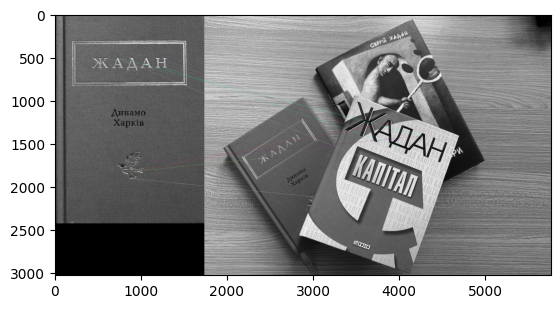

(<matplotlib.image.AxesImage at 0x7f759f46c400>, None)

In [4]:
img1 = Image.open('images/sample_1.jpg')
img2 = Image.open('images/sample_1_in_scene.jpg')

ORB(img1, img2)

scales:  [1, 2]

pyramid layer:  1
scales[i]:  2
scale_coeff1:  (2.0, 2.0)
scale_coeff2:  (2.0, 2.0)
grays1[i] shape:  (435, 491)
grays2[i] shape:  (2016, 1512)
kp1:  3390
kp2:  48991


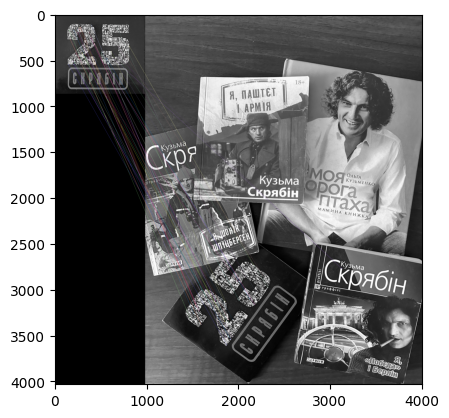

(<matplotlib.image.AxesImage at 0x7f759f372cd0>, None)

In [5]:
img1 = Image.open('images/sample_2.jpg')
img2 = Image.open('images/sample_2_in_scene.jpg')

ORB(img1, img2)

scales:  [1, 2]

pyramid layer:  1
scales[i]:  2
scale_coeff1:  (2.0, 2.0)
scale_coeff2:  (2.0, 2.0)
grays1[i] shape:  (180, 270)
grays2[i] shape:  (1296, 1936)
kp1:  407
kp2:  76445


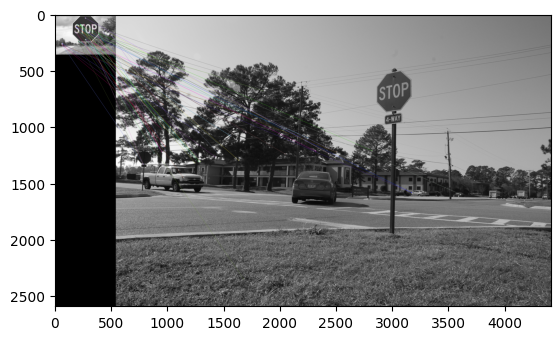

(<matplotlib.image.AxesImage at 0x7f759f2f90a0>, None)

In [6]:
img1 = Image.open('images/sample_3.jpg')
img2 = Image.open('images/sample_3_in_scene.jpeg')

ORB(img1, img2)